<a href="https://colab.research.google.com/github/shivamishu/cmpe255/blob/main/GMM_and_Hierarchical_Clusteringipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GMM and Hierarchical clustering

**Shivam Shrivastav**

# **GMM**

In [ ]:
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from sklearn import mixture
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive'

/content/drive/MyDrive


In [ ]:
train = pd.read_csv('train.csv')
train = train.sample(frac=1)
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
3449,0.270919,-0.023432,-0.118623,-0.997773,-0.990879,-0.984508,-0.998272,-0.991507,-0.984466,-0.943957,-0.574445,-0.823137,0.849447,0.687594,0.831095,-0.989112,-0.999980,-0.999878,-0.999521,-0.998634,-0.993577,-0.983717,-0.861875,-0.876702,-0.722633,0.102089,0.019998,-0.288616,0.328994,0.108086,-0.082799,0.054624,0.093863,0.245008,-0.124305,-0.002952,-0.025995,0.166246,0.313672,-0.138939,...,-1.000000,-0.968254,0.599638,-0.447260,-0.684288,-0.992358,-0.985804,-0.988574,-0.984375,-0.998081,-0.992358,-0.999871,-0.993905,-0.797549,-0.948718,-0.285277,0.129149,-0.233818,-0.997749,-0.997357,-0.997060,-0.998019,-0.998212,-0.997749,-0.999990,-0.997252,-1.000000,-0.936508,0.295653,-0.543683,-0.857082,0.000103,-0.111407,0.298576,-0.406669,-0.664465,0.320676,0.083237,17,STANDING
6315,0.276949,-0.017632,-0.115238,-0.988073,-0.957196,-0.969736,-0.989454,-0.959304,-0.966888,-0.931976,-0.548413,-0.805648,0.835723,0.679197,0.831322,-0.975203,-0.999878,-0.999488,-0.999099,-0.991117,-0.968827,-0.956869,-0.461400,-0.411758,-0.501796,0.293515,-0.141184,0.113620,0.618118,-0.075305,0.173038,-0.052177,0.447444,0.050920,0.054563,-0.070374,0.168165,0.421862,-0.022532,0.540174,...,-0.940965,-1.000000,0.215117,-0.385885,-0.725528,-0.982361,-0.983989,-0.981953,-0.988169,-0.991657,-0.982361,-0.999766,-0.981991,-0.664203,-0.897436,0.104326,-0.531608,-0.840991,-0.991112,-0.991073,-0.991358,-0.989794,-0.995994,-0.991112,-0.999932,-0.992230,-0.923452,-1.000000,0.393943,0.023532,-0.262154,-0.015807,0.205988,-0.036548,-0.013271,-0.797652,0.229359,0.067881,28,SITTING
595,0.256579,-0.027866,-0.044736,-0.961579,-0.954003,-0.954508,-0.970202,-0.958089,-0.958705,-0.870466,-0.553127,-0.765932,0.822464,0.654992,0.833987,-0.930106,-0.999012,-0.999215,-0.992488,-0.976903,-0.971849,-0.965392,-0.483428,-0.701667,0.065711,-0.188312,0.113948,-0.134666,0.200028,-0.284238,0.311543,-0.035481,-0.150070,-0.059430,-0.089791,0.165441,-0.111529,0.217413,-0.488330,-0.341802,...,-0.828516,-1.000000,-0.231950,-0.025591,-0.490678,-0.911899,-0.875586,-0.887216,-0.876075,-0.921507,-0.911899,-0.991940,-0.

In [ ]:
test = pd.read_csv('test.csv')
test = test.sample(frac=1)
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2257,0.267124,-0.006546,-0.105159,-0.993415,-0.959532,-0.982664,-0.993831,-0.962292,-0.983066,-0.942294,-0.542800,-0.816942,0.842386,0.677867,0.834308,-0.979023,-0.999929,-0.999332,-0.999610,-0.993367,-0.972006,-0.981852,-0.751869,-0.161020,-0.450762,-0.027847,0.024801,-0.133901,0.099053,0.033475,-0.210527,0.326254,0.015631,0.405732,-0.247841,0.257113,-0.233290,-0.654833,-0.540556,0.631676,...,-1.000000,-1.000000,0.122543,-0.532035,-0.826202,-0.988104,-0.980588,-0.980527,-0.979816,-0.996649,-0.988104,-0.999768,-0.988648,-0.720891,-1.000000,-0.398478,-0.130302,-0.453497,-0.995896,-0.993861,-0.994730,-0.993284,-0.995421,-0.995896,-0.999973,-0.995595,-0.955696,-1.000000,0.030266,0.067971,-0.304794,0.077208,0.007521,0.133913,-0.340106,-0.619962,-0.030756,-0.220404,20,SITTING
2115,0.298267,-0.017900,-0.108838,-0.986019,-0.981462,-0.980940,-0.986688,-0.983515,-0.981824,-0.921721,-0.564495,-0.819192,0.840955,0.680293,0.829556,-0.983078,-0.999757,-0.999863,-0.999572,-0.987405,-0.988217,-0.986737,-0.126547,-0.611601,-0.525435,-0.035003,-0.005411,0.236087,-0.371951,-0.024324,0.126063,0.045106,-0.022601,0.318253,-0.195169,0.218696,-0.160359,-0.104152,-0.592946,-0.111369,...,-1.000000,-0.809524,0.248630,-0.772310,-0.936426,-0.985251,-0.986722,-0.983447,-0.989817,-0.996166,-0.985251,-0.999829,-0.979804,-0.713184,-0.743590,0.100602,-0.658624,-0.893617,-0.988337,-0.991063,-0.989033,-0.993318,-0.991943,-0.988337,-0.999910,-0.987550,-0.871306,-0.809524,0.282582,-0.612958,-0.894264,-0.054314,0.010343,0.503265,0.241267,0.409178,-0.307185,-0.682248,18,LAYING
2167,0.302583,-0.022107,-0.147346,-0.408051,-0.232392,-0.392991,-0.468121,-0.241787,-0.396380,-0.184356,-0.249087,-0.506333,0.381231,0.135806,0.460844,-0.329994,-0.823337,-0.885286,-0.829150,-0.637769,-0.415407,-0.429245,0.210917,0.311622,0.155713,-0.393453,0.198652,0.061488,0.045129,-0.559519,0.585239,-0.384631,0.185904,-0.436074,0.440924,-0.385015,0.088444,-0.448617,-0.622999,0.493982,...,0.026986,-0.904762,-0.057811,0.140229,-0.158332,-0.372086,-0.025288,-0.218247,0.043886,-0.640450,-0.372086,-0.546251,-0.63

In [ ]:
X_train = train.iloc[:,:-2]
Y_train = train.Activity
train = train.drop(['Activity', 'subject'], axis=1)
print(Y_train.shape)

(7352,)


In [ ]:
X_test = test.iloc[:,:-2]
Y_test = test.Activity
test = test.drop(['Activity', 'subject'], axis=1)
print(Y_test.shape)

(2947,)


**Comparing GMM vs K-means**

Disadvantages of k-means are: its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well.

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means

**How many components?**

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

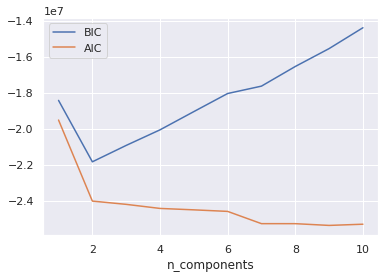

In [ ]:
n_components = np.arange(1, 11)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(train)
          for n in n_components]

plt.plot(n_components, [m.bic(train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

**Findings**

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 6 components below was probably too many: around 2-4 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.


**With n_components = 6**

In [ ]:
# define the model
gaussian_model = mixture.GaussianMixture(n_components=6)

# train the model
gaussian_model.fit(train)

# assign each data point to a cluster
gaussian_result = gaussian_model.predict(train)
print(gaussian_result)

# get all of the unique clusters
gaussian_clusters = np.unique(gaussian_result)
print(gaussian_clusters)


[1 1 4 ... 1 1 5]
[0 1 2 3 4 5]


In [ ]:
df = pd.DataFrame({'clust_label': gaussian_result, 'orig_label': np.array(Y_train)})
ct = pd.crosstab(df['clust_label'], df['orig_label'])

display(ct)

orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
0,0,0,0,802,84,156
1,0,1222,1368,0,0,0
2,0,0,0,101,604,121
3,0,0,0,93,202,36
4,1387,56,0,0,0,0
5,20,8,6,230,96,760


But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [ ]:
probs = gaussian_model.predict_proba(train)
print(probs[:5].round(3))

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


**Performing TSNE transformation to plot data**

In [ ]:
tsne_data = train.copy()
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)

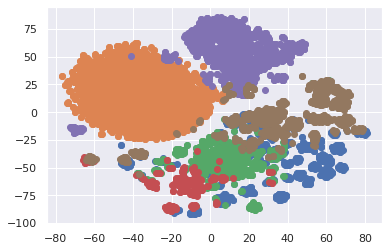

In [ ]:
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# plot Gaussian Mixture the clusters
for gaussian_cluster in gaussian_clusters:
    # get data points that fall in this cluster
    index = np.where(gaussian_result == gaussian_cluster)
    # make the plot
    pyplot.scatter(tsne_transformed[index, 0], tsne_transformed[index, 1])

# show the Gaussian Mixture plot
pyplot.show()

**With n_components = 2**

In [ ]:
# define the model
gaussian_model = mixture.GaussianMixture(n_components=2)

# train the model
gaussian_model.fit(train)

# assign each data point to a cluster
gaussian_result = gaussian_model.predict(train)
print(gaussian_result)

# get all of the unique clusters
gaussian_clusters = np.unique(gaussian_result)
print(gaussian_clusters)

[0 0 0 ... 0 0 1]
[0 1]


In [ ]:
df = pd.DataFrame({'clust_label': gaussian_result, 'orig_label': np.array(Y_train)})
ct = pd.crosstab(df['clust_label'], df['orig_label'])

display(ct)

orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
0,1396,1285,1374,0,0,0
1,11,1,0,1226,986,1073


In [ ]:
probs = gaussian_model.predict_proba(train)
print(probs[:5].round(3))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Plotting clusters

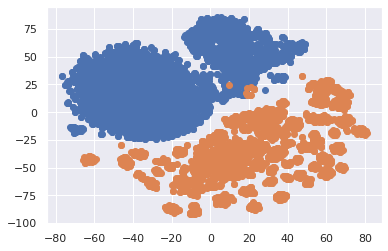

In [ ]:
# plot Gaussian Mixture the clusters
for gaussian_cluster in gaussian_clusters:
    # get data points that fall in this cluster
    index = np.where(gaussian_result == gaussian_cluster)
    # make the plot
    pyplot.scatter(tsne_transformed[index, 0], tsne_transformed[index, 1])

# show the Gaussian Mixture plot
pyplot.show()

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### Plotting 2-component GMM gives us for our initial data:

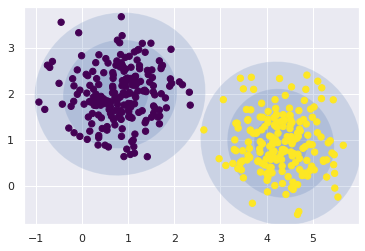

In [ ]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=2,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

gmm = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

### GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

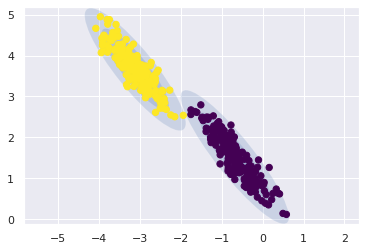

In [ ]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

plot_gmm(gmm, X_stretched)

# Hierarchical (Agglomerative Clustering)


[1 0 5 ... 2 4 1]


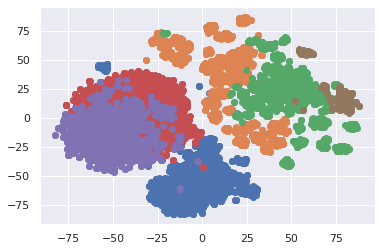

In [ ]:
# define the model
agglomerative_model = AgglomerativeClustering(n_clusters=6)

# assign each data point to a cluster
agglomerative_result = agglomerative_model.fit_predict(train)
print(agglomerative_result)
# get all of the unique clusters
agglomerative_clusters = np.unique(agglomerative_result)

# plot the clusters
for agglomerative_cluster in agglomerative_clusters:
    # get data points that fall in this cluster
    index = np.where(agglomerative_result == agglomerative_cluster)
    # make the plot
    plt.scatter(tsne_transformed[index, 0], tsne_transformed[index, 1])

# show the Agglomerative Hierarchy plot
plt.show()

[1 0 1 ... 1 0 1]


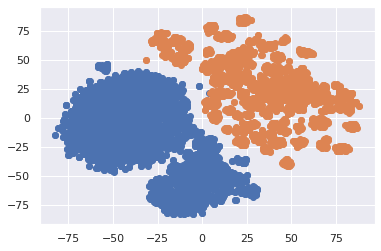

In [ ]:
# define the model
agglomerative_model = AgglomerativeClustering(n_clusters=2)

# assign each data point to a cluster
agglomerative_result = agglomerative_model.fit_predict(train)
print(agglomerative_result)
# get all of the unique clusters
agglomerative_clusters = np.unique(agglomerative_result)

# plot the clusters
for agglomerative_cluster in agglomerative_clusters:
    # get data points that fall in this cluster
    index = np.where(agglomerative_result == agglomerative_cluster)
    # make the plot
    plt.scatter(tsne_transformed[index, 0], tsne_transformed[index, 1])

# show the Agglomerative Hierarchy plot
plt.show()

Name: Shivam Shrivastav  
Student ID: 015275000  

Data Set  
The data set I used for the assignment is "User Activity Recognition" available on Kaggle:   
https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones
The data was collected using a smartphone. Each user, who contributed the data, performed the following 6 activities wearing a smartphone on their waist: LAYING, SITTING, STANDING, WALKING,WALKING_DOWNSTAIRS, WALKING_UPSTAIRS.
 
 
 


Findings:   

Compare and contrast your recent clusterings (2) with the previous K-means.
 

KMeans Randomly assign initial data points to its nearest cluster.


GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions.

Hierarchical clustering follows a bottom up approach dividing the data point into a different cluster. 
Randomly assign initial clusters, assign each sample to its nearest centroid then get new centroids by averaging out the assignment.


GMM is flexible with the boundaries since they have covariance types.
The bottom up approach creates n clusters for n data points and then merges them to nearest clusters they belong to.
K-means begins with a random cluster center, thus, it gives different clustering results on different runs of the algorithm.
 
K-means clustering requires prior knowledge for the value of K.

GMM is flexible with the boundaries as they have covariance types.

In hierarchical clustering we can stop at whichever cluster we want. The results remain the same in every iteration of the algorithm.

KMeans lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well.


A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.


Hierarchical clustering requires the computation and storage of an n×n  distance matrix. For very large datasets, this can be expensive and slow.



	

